# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 02.02.2024

Мягкий дедлайн: 23:59MSK 19.02.2024

Жесткий дедлайн: 23:59MSK 25.02.2024

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

Загрузим все необходимые библиотеки.

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import math
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import time
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

Почему-то нормальным способом у меня датасет не загрузился, так что будем скачивать вручную. А еще код не запускался нигде кроме кэггла))

In [7]:
train = pd.read_csv('/kaggle/input/fashion-mnist-train-csv/fashion-mnist_train.csv')
test = pd.read_csv('/kaggle/input/fashion-mnist-test-csv/fashion-mnist_test.csv')

y_train = train['label'].values
x_train = train.drop('label', axis=1).values

y_test = test['label'].values
x_test = test.drop('label', axis=1).values

Если данные не отскейлить, то аккураси получается около 0.1, так что мы это обязательно сделаем.

In [8]:
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

pipeline.fit(x_train)

x_train = pipeline.transform(x_train)
x_test = pipeline.transform(x_test)


__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.

        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.

        use_PCA, bool: whether to include PCA preprocessing.

        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.

        Feel free to edit this template for your preferences.
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier

    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        if self.use_PCA == True: # Если используем PCA:
            pca = PCA(n_components = self.new_dim) # Инициализируем PCA
            X = pca.fit_transform(X) # Обучаем PCA
            self.pca = pca # Сохраняем обученный PCA
            
        sample = np.random.choice(len(X) - 1, size = [2, 1000000]) # Случайное подмножество из миллион пар объектов
        sample  = (sample.T[sample[0] != sample[1]]).T # Убираем элементы с одинаковыми индексами
        distance = pairwise_distances(X[sample[0]], X[sample[1]], metric = 'euclidean') # Вычисляем попарные расстояния между выбранными элементами
        var = np.median(distance ** 2) # Вычисляем медиану квадратов расстояний
        weight = np.random.normal(0, np.sqrt(1 / var), (self.n_features, X.shape[1])) # Инициализируем веса
        self.weight = weight # Сохраняем их значения
        b = np.random.uniform(-math.pi, math.pi, self.n_features) # Инициализируем сдвиги
        self.b = b # Сохраняем их значения
        X = np.cos((X @ weight.T) + b) # Применяем преобразования к данным
        
        if self.classifier == 'logreg':
            model =  LogisticRegression()
        else:
            model = SVC(kernel = 'linear', probability = True)
            
        model.fit(X, y) # Обучаем модель
        self.model = model # Сохраняем ее
        
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA == True: # Если используем PCA:
            X = self.pca.transform(X) # Трансформируем, используя наш PCA
        X = np.cos((X @ self.weight.T) + self.b) # Добавляем новые признаки
        return self.model.predict_proba(X) #  Возвращаем вероятности

    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if self.use_PCA == True: # Если используем PCA:
            X = self.pca.transform(X) # Трансформируем, используя наш PCA
        X = np.cos((X @ self.weight.T) + self.b) # Добавляем новые признаки
        return self.model.predict(X) # Возвращаем предсказания

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

Применяем PCA.

In [7]:
pca = PCA(n_components = 50) # Ставим параметр по умолчанию
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

Используем подход со случайными признаками (Random Fouirier Features).

По времени он обучается за 47 секунд.

In [9]:
now = time.time()
rff = RFFPipeline(classifier = 'svm')
rff.fit(x_train[:10000], y_train[:10000])
print(time.time() - now)

46.84043312072754


И точность на тесте равна 0.8565.

In [10]:
print(accuracy_score(rff.predict(x_test), y_test))

0.8565


Теперь обучим линейный SVM. Тут скорость обучения зависит от параметра max_iter. Я не смогла подобрать нормальный, чтобы не было ConvergenceWarning, т.к. даже для 50000 он не сходился. Но в целом даже на max_iter = 1000 он дает неплохую точность - 0.8122. И обучается довольно быстро, за 9.78 секунд.

In [13]:
now = time.time()
linearsvc = LinearSVC(max_iter = 1000)
linearsvc.fit(x_train[:10000], y_train[:10000])
print(time.time() - now)

9.780688762664795


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [16]:
print(accuracy_score(linearsvc.predict(x_test), y_test))

0.8122


И теперь ядровой SVM. Он обучился очень быстро - за 1.75 секунды. И дал хорошую точность в 0.848.

In [17]:
now = time.time()
svc = SVC(kernel = 'rbf')
svc.fit(x_train[:10000], y_train[:10000])
print(time.time() - now)

1.7512505054473877


In [18]:
print(accuracy_score(svc.predict(x_test), y_test))

0.848


Результат: самым точным оказался наш Random Fourier Features, но он довольно медленный. Линейный SVM проигрывает по качеству, но, если подобрать правильный параметр max_iter, то, наверное, он не будет сильно уступать другим методам, но будет работать значительно дольше.

Теперь бустинг:)

Разделим трейн на валидационную и обучающую выборку, чтобы подобрать параметры.

In [36]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state = 42)

Создадим сетки для поиска гиперпараметров.

In [23]:
num_iteration_grid = [50, 100, 125]
learning_rate_grid = [0.05, 0.1, 0.2]

In [19]:
results = []
for num_iterations in num_iteration_grid:
    for learning_rate in learning_rate_grid:
        boost = CatBoostClassifier(iterations = num_iterations, learning_rate = learning_rate)
        boost.fit(x_train, y_train)
        accuracy = accuracy_score(boost.predict(x_val), y_val)
        results.append((accuracy, num_iterations, learning_rate))
max_accuracy, best_num_iterations, best_learning_rate = max(results, key = lambda x: x[0])
print(f"num_iterations = {best_num_iterations}, learning_rate = {best_learning_rate}")

num_iterations = 125, learning_rate = 0.2


Применим PCA.

In [38]:
pca = PCA(n_components = 50)
x_train = pca.fit_transform(x_train)

In [45]:
now = time.time()
boost = CatBoostClassifier(iterations = 125, learning_rate = 0.2, verbose = False)
boost.fit(x_train[:10000], y_train[:10000])
print(time.time() - now)

151.71660733222961


In [44]:
accuracy_score(boost.predict(x_test), y_test)

0.8814

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA?
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

Обучим модель без понижения размерности.

In [13]:
now = time.time()
rff = RFFPipeline(use_PCA = False)
rff.fit(x_train[:10000], y_train[:10000])
print(time.time() - now)

272.54235911369324


In [20]:
print(accuracy_score(rff.predict(x_test), y_test))

0.8432


А теперь с PCA.

In [14]:
now = time.time()
rff = RFFPipeline()
rff.fit(x_train[:10000], y_train[:10000])
print(time.time() - now)

208.5310869216919


In [21]:
print(accuracy_score(rff.predict(x_test), y_test))

0.861


Получается, что обучение с PCA быстрее и дает лучшее качество.

Инициализируем списое из вариантов значений параметра n_features и списки, в которых будем записывать точность.

In [10]:
n_features_list = [200, 600, 1000, 1400, 1800]
accuracy_lst_lr = []
accuracy_lst_svm = []

Обучаем логрег с параметрами из списка.

In [23]:
for n in n_features_list:
    rff = RFFPipeline(n_features = n)
    rff.fit(x_train[:10000], y_train[:10000])
    accuracy_lst_lr.append(accuracy_score(rff.predict(x_test), y_test))

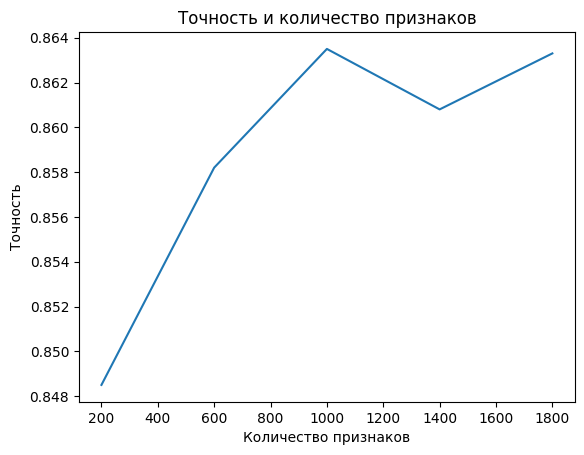

In [4]:
plt.figure()
plt.plot(n_features_list, accuracy_lst_lr, label = 'Точность')
plt.xlabel('Количество признаков')
plt.ylabel('Точность')
plt.title('Точность и количество признаков')
plt.show()

Здесь качество сначала быстро растет, а затем, после 1000, выходит на плато. 

Делаем то же самое для SVM.

In [ ]:
for n in n_features_list:
    rff = RFFPipeline(n_features = n, classifier = 'svm')
    rff.fit(x_train[:10000], y_train[:10000])
    accuracy_lst_svm.append(accuracy_score(rff.predict(x_test), y_test))

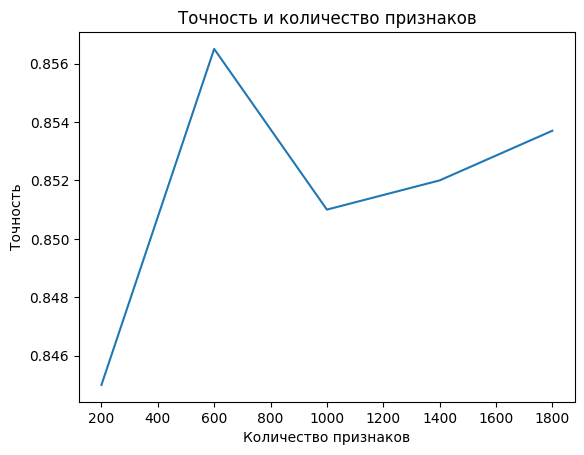

In [19]:
plt.figure()
plt.plot(n_features_list, accuracy_lst_svm, label = 'Точность')
plt.xlabel('Количество признаков')
plt.ylabel('Точность')
plt.title('Точность и количество признаков')
plt.show()

Здесь качество сильно колеблется и на плато, кажется, выйдет при большем значении параметра n_features. 

Логистическая регрессия обучается быстрее SVM, и в пределе дает бОльшую точность.

__Задание 5. (Максимум 1 балл)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
class RFFPipelinewf(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', func='cos'):
        """
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.

        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.

        use_PCA, bool: whether to include PCA preprocessing.

        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.

        Feel free to edit this template for your preferences.
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.func = func

    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        if self.use_PCA == True: # Если используем PCA:
            pca = PCA(n_components = self.new_dim) # Инициализируем PCA
            X = pca.fit_transform(X) # Обучаем PCA
            self.pca = pca # Сохраняем обученный PCA
        sample = np.random.choice(X.shape[0] - 1, size = [2, 1000000]) # Случайное подмножество из миллион пар объектов
        sample  = (sample.T[sample[0] != sample[1]]).T # Убираем элементы с одинаковыми индексами
        distance = pairwise_distances(X[sample[0]], X[sample[1]], metric = 'euclidean') # Вычисляем попарные расстояния между выбранными элементами
        var = np.median(distance ** 2) # Вычисляем медиану квадратов расстояний
        weight = np.random.normal(0, np.sqrt(1 / var), (self.n_features, X.shape[1])) # Инициализируем веса
        self.weight = weight # Сохраняем их значения
        b = np.random.uniform(-math.pi, math.pi, self.n_features) # Инициализируем сдвиги
        self.b = b # Сохраняем их значения
        if self.func == 'sin':
            X = np.sin((X @ weight.T) + b) 
        elif self.func == 'cos':
            X = np.cos((X @ weight.T) + b) 
        elif self.func == 'sign':
            X = np.sign((X @ weight.T) + b)
        elif self.func == 'sigmoid':
            X = 1 / (1 + np.exp(-(X @ weight.T + b)))
        elif self.func == 'tanh':
            X = np.tanh(X @ weight.T + b)
        elif self.func == 'relu':
            X = np.maximum(0, X @ weight.T + b)
                        
        if self.classifier == 'logreg':
            model =  LogisticRegression()
        else:
            model = SVC(kernel = 'linear', probability = True)
            
        model.fit(X, y) # Обучаем модель
        self.model = model # Сохраняем ее
        
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
                        
        if self.func == 'sin':
            X = np.sin((X @ self.weight.T) + self.b) 
        elif self.func == 'cos':
            X = np.cos((X @ self.weight.T) + self.b) 
        elif self.func == 'sign':
            X = np.sign((X @ self.weight.T) + self.b)
        elif self.func == 'sigmoid':
            X = 1 / (1 + np.exp(-(X @ self.weight.T + self.b)))
        elif self.func == 'tanh':
            X = np.tanh(X @ self.weight.T + self.b)
        elif self.func == 'relu':
            X = np.maximum(0, X @ self.weight.T + self.b)

        return self.model.predict_proba(X)

    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)

        if self.func == 'sin':
            X = np.sin((X @ self.self.weight.T) + self.b) 
        elif self.func == 'cos':
            X = np.cos((X @ self.weight.T) + self.b) 
        elif self.func == 'sign':
            X = np.sign((X @ self.weight.T) + self.b)
        elif self.func == 'sigmoid':
            X = 1 / (1 + np.exp(-(X @ self.weight.T + self.b)))
        elif self.func == 'tanh':
            X = np.tanh(X @ self.weight.T + self.b)
        elif self.func == 'relu':
            X = np.maximum(0, X @ self.weight.T + self.b)

        return self.model.predict(X)

In [ ]:
accuracy_lst = []

In [33]:
for func in ['sin', 'cos', 'sign', 'sigmoid', 'tanh', 'relu']:
    rff = RFFPipelinewf(func = func)
    rff.fit(x_train[:10000], y_train[:10000])
    accuracy_lst.append(accuracy_score(rff.predict(x_test), y_test))
print(accuracy_lst)

[0.8635, 0.8616, 0.7977, 0.6445, 0.861, 0.8544]


Самую высокую точность, как и ожидалось, дал синус. Косинус и тангенс дали похожие результаты. На удивление, на relu тоже получилось хорошее качество. Хуже всего результат у сигмоиды.